## Generate sounds with Variational AutoEncoder


In [1]:
#!pip install imutils
#!/opt/conda/bin/python3.7 -m pip install --upgrade pip
#!pip install tensorflow-addons
#!pip install --upgrade --ignore-installed tensorflow
#!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
pip install tfa-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
#pip install librosa 

In [4]:
#pip install pandas

In [5]:
#pip install matplotlib

In [6]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

2.6.4


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [7]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-09-05 15:07:14.506858: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-05 15:07:14.579942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:07:14.739970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:07:14.741222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
train_size = 60000
BATCH_SIZE = 10
test_size = 10000
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10
#BASE_PATH = '/media/thanh/Samsung_T5/BackupData/3rdYear2021/29.Paper4/ValmetDataset/ValmetRawSound/Data/'
BASE_PATH = '../input/valmetab/Valmet'

## Data preprocessing

In [9]:
def DatasetLoader(class_):
    sound_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_sound_1 = list(sound_list[[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66]]) 
    train_sound_2 = list(sound_list[[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65]]) 
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_sound_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_sound_2]

    return TrackSet_1, TrackSet_2

In [10]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=96000, offset=0.0, duration=0.02083)
    # Thanh
    input_fixed_length = 1
    if len(data_) < input_fixed_length:
        nb_replicas = int(np.ceil(input_fixed_length / len(data_)))
        data_rep = np.tile(data_, (nb_replicas, 1))
        data_ = data_rep[:input_fixed_length]  
    
    data_ = data_.reshape(1,1999)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [11]:
TrackSet_1, TrackSet_2 = DatasetLoader('Anomaly')

## sample original sound

In [12]:
sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=96000, offset=0.0, duration=0.02083)
ipd.Audio(sample_,rate=1999)

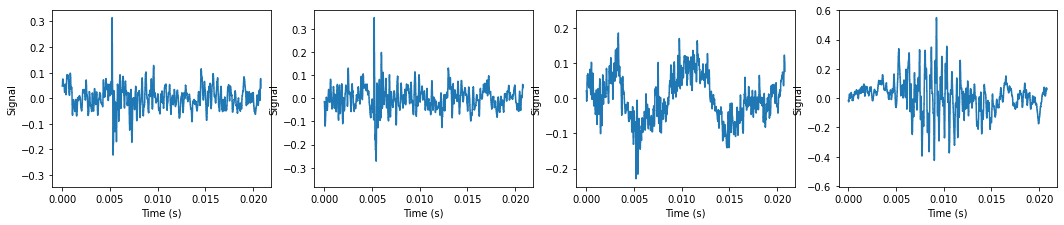

In [13]:
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    #librosa.display.waveplot(j[0], sr=96000)
    librosa.display.waveshow(j[0], sr=96000)
    ax = plt.gca()
    ax.set_xlabel('Time (s)')   
    ax.set_ylabel("Signal")   

In [14]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

2022-09-05 15:07:19.510867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:07:19.511844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:07:19.512577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:07:19.515323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:07:19.516730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## Network architecture

In [15]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__(name='')
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)


In [16]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,1999)),
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(1999,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [17]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [18]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [19]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Loss Optimization
Here we have optimized two lossess, the **KL loss** and **reconstruction loss**.<br>

## Reconstruction loss
As the name suggest, it measures the reconstruction of original input x. This network can be trained by minimizing the reconstruction error, which measures the differences between our original input and the consequent reconstruction.

In [20]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [21]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [22]:
import librosa.display
save_sound=[]
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        if epoch>14:
            save_sound.append(wave)
        #librosa.display.waveplot(wave[0], sr=96000)
        librosa.display.waveshow(wave[0], sr=96000)      

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('anomaly_{:04d}.png'.format(epoch))
    plt.savefig('anomaly_{:04d}.png'.format(epoch))
    plt.show()

In [23]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

2022-09-05 15:07:21.947223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Training the model

Epoch: 20, Test set ELBO: 114.40557098388672, time elapse for current epoch: 0.07177209854125977


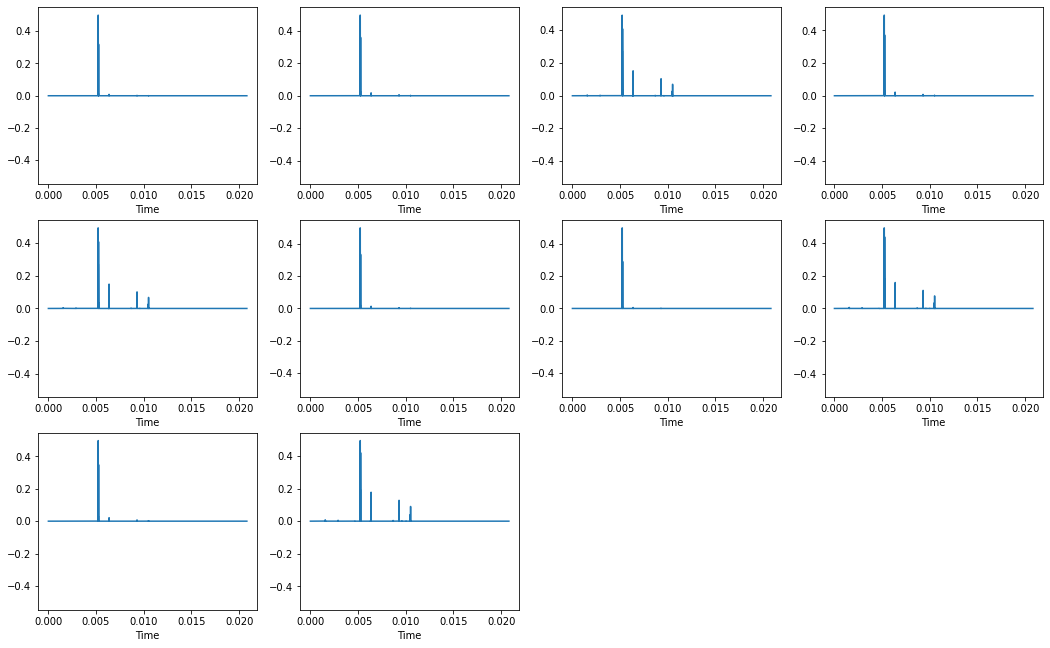

In [24]:
generate_and_save_images(model, 0, test_sample)
#def train(train_dataset, test_dataset, model, save):
for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
        generate_and_save_images(model, epoch, test_sample)
        #train(train_dataset, test_dataset, model, 'Anomaly')
    

In [25]:
anim_file_1 = 'anomaly_cvae.gif'
#anim_file_1 = 'sound_cvae.gif'
with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('anomaly*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.v3.imread(filename)
        writer.append_data(image)
    image = imageio.v3.imread(filename)
    writer.append_data(image)

## Visualization

In [26]:
#import tensorflow_docs.vis.embed as embed
#embed.embed_file(anim_file_1)

## Generated Sound
We can listen to the generated sound by the model

In [27]:
import soundfile as sf

In [28]:
x = len(save_sound) 
print(x)

60


In [29]:
b1=save_sound[0][0]
ipd.Audio(b1,rate=96000)
sf.write('gen1.wav', b1, 96000)  

In [30]:
b2=save_sound[1][0]
ipd.Audio(b2,rate=96000)
sf.write('gen2.wav', b2, 96000)  

In [31]:
b3=save_sound[2][0]
ipd.Audio(b3,rate=96000)
sf.write('gen3.wav', b3, 96000)  

In [32]:
b4=save_sound[3][0]
ipd.Audio(b4,rate=96000)
sf.write('gen4.wav', b4, 96000)  

In [33]:
b5=save_sound[4][0]
ipd.Audio(b5,rate=96000)
sf.write('gen5.wav', b5, 96000)  

In [34]:
b6=save_sound[5][0]
ipd.Audio(b6,rate=96000)
sf.write('gen6.wav', b6, 96000)  

In [35]:
b7=save_sound[6][0]
ipd.Audio(b7,rate=96000)
sf.write('gen7.wav', b7, 96000)  

In [36]:
b8=save_sound[7][0]
ipd.Audio(b8,rate=96000)
sf.write('gen8.wav', b8, 96000)  

In [37]:
b9=save_sound[8][0]
ipd.Audio(b9,rate=96000)
sf.write('gen9.wav', b9, 96000)  

In [38]:
b10=save_sound[9][0]
ipd.Audio(b10,rate=96000)
sf.write('gen10.wav', b10, 96000)  

In [39]:
b11=save_sound[10][0]
ipd.Audio(b11,rate=96000)
sf.write('gen11.wav', b11, 96000)  

In [40]:
b12=save_sound[11][0]
ipd.Audio(b12,rate=96000)
sf.write('gen12.wav', b12, 96000)  

In [41]:
b13=save_sound[12][0]
ipd.Audio(b13,rate=96000)
sf.write('gen13.wav', b13, 96000)  

In [42]:
b14=save_sound[13][0]
ipd.Audio(b14,rate=96000)
sf.write('gen14.wav', b14, 96000)  

In [43]:
b15=save_sound[14][0]
ipd.Audio(b15,rate=96000)
sf.write('gen15.wav', b15, 96000)  

In [44]:
b16=save_sound[15][0]
ipd.Audio(b16,rate=96000)
sf.write('gen16.wav', b16, 96000)  

In [45]:
b17=save_sound[16][0]
ipd.Audio(b17,rate=96000)
sf.write('gen17.wav', b17, 96000)  

In [46]:
b18=save_sound[17][0]
ipd.Audio(b18,rate=96000)
sf.write('gen18.wav', b18, 96000)  

In [47]:
b19=save_sound[18][0]
ipd.Audio(b16,rate=96000)
sf.write('gen19.wav', b19, 96000)  

In [48]:
b20=save_sound[19][0]
ipd.Audio(b20,rate=96000)
sf.write('gen20.wav', b20, 96000)  

In [49]:
b21=save_sound[20][0]
ipd.Audio(b21,rate=96000)
sf.write('gen21.wav', b21, 96000)  

In [50]:
b22=save_sound[21][0]
ipd.Audio(b22,rate=96000)
sf.write('gen22.wav', b22, 96000)  

In [51]:
b23=save_sound[22][0]
ipd.Audio(b23,rate=96000)
sf.write('gen23.wav', b23, 96000)  

In [52]:
b24=save_sound[23][0]
ipd.Audio(b24,rate=96000)
sf.write('gen24.wav', b24, 96000)  

In [53]:
b25=save_sound[24][0]
ipd.Audio(b25,rate=96000)
sf.write('gen25.wav', b25, 96000)  

In [54]:
b26=save_sound[25][0]
ipd.Audio(b26,rate=96000)
sf.write('gen26.wav', b26, 96000)  

In [55]:
b27=save_sound[26][0]
ipd.Audio(b27,rate=96000)
sf.write('gen27.wav', b27, 96000)  

In [56]:
b28=save_sound[27][0]
ipd.Audio(b28,rate=96000)
sf.write('gen28.wav', b28, 96000)  

In [57]:
b29=save_sound[28][0]
ipd.Audio(b29,rate=96000)
sf.write('gen29.wav', b29, 96000)  

In [58]:
b30=save_sound[29][0]
ipd.Audio(b30,rate=96000)
sf.write('gen30.wav', b30, 96000)  

In [59]:
b31=save_sound[30][0]
ipd.Audio(b31,rate=96000)
sf.write('gen31.wav', b31, 96000)  

In [60]:
b32=save_sound[31][0]
ipd.Audio(b32,rate=96000)
sf.write('gen32.wav', b32, 96000)  

In [61]:
b33=save_sound[32][0]
ipd.Audio(b33,rate=96000)
sf.write('gen33.wav', b33, 96000)  

In [62]:
b34=save_sound[33][0]
ipd.Audio(b34,rate=96000)
sf.write('gen34.wav', b34, 96000)  

In [63]:
b35=save_sound[34][0]
ipd.Audio(b35,rate=96000)
sf.write('gen35.wav', b35, 96000)  

In [64]:
b36=save_sound[35][0]
ipd.Audio(b36,rate=96000)
sf.write('gen36.wav', b36, 96000)  

In [65]:
b37=save_sound[36][0]
ipd.Audio(b37,rate=96000)
sf.write('gen37.wav', b37, 96000)  

In [66]:
b38=save_sound[37][0]
ipd.Audio(b38,rate=96000)
sf.write('gen38.wav', b38, 96000)  

In [67]:
b39=save_sound[38][0]
ipd.Audio(b39,rate=96000)
sf.write('gen39.wav', b39, 96000)  

In [68]:
b40=save_sound[39][0]
ipd.Audio(b40,rate=96000)
sf.write('gen40.wav', b40, 96000)  

In [69]:
b41=save_sound[40][0]
ipd.Audio(b41,rate=96000)
sf.write('gen41.wav', b41, 96000)  

In [70]:
b42=save_sound[41][0]
ipd.Audio(b42,rate=96000)
sf.write('gen42.wav', b42, 96000)  

In [71]:
b43=save_sound[42][0]
ipd.Audio(b43,rate=96000)
sf.write('gen43.wav', b43, 96000)  

In [72]:
b44=save_sound[43][0]
ipd.Audio(b44,rate=96000)
sf.write('gen44.wav', b44, 96000)  

In [73]:
b45=save_sound[44][0]
ipd.Audio(b45,rate=96000)
sf.write('gen45.wav', b45, 96000)  

In [74]:
b46=save_sound[45][0]
ipd.Audio(b46,rate=96000)
sf.write('gen46.wav', b46, 96000)  

In [75]:
b47=save_sound[46][0]
ipd.Audio(b47,rate=96000)
sf.write('gen47.wav', b47, 96000)  

In [76]:
b48=save_sound[47][0]
ipd.Audio(b48,rate=96000)
sf.write('gen48.wav', b48, 96000)  

In [77]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-09-05 15:09:00.879008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:09:00.880180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:09:00.881088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:09:00.881793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:09:00.882391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

The same experiment for sounds in the "Normal" category

In [78]:
TrackSet_3, TrackSet_4 = DatasetLoader('Normal')

In [79]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_3))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_4))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

In [80]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [81]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [82]:
import librosa.display

save_sound_U=[]
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        if epoch>15:
            save_sound_U.append(wave)
        librosa.display.waveshow(wave[0], sr=96000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('normal_{:04d}.png'.format(epoch))
    plt.savefig('normal_{:04d}.png'.format(epoch))
    plt.show()

In [83]:
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

Epoch: 20, Test set ELBO: 35579.75, time elapse for current epoch: 0.08116698265075684


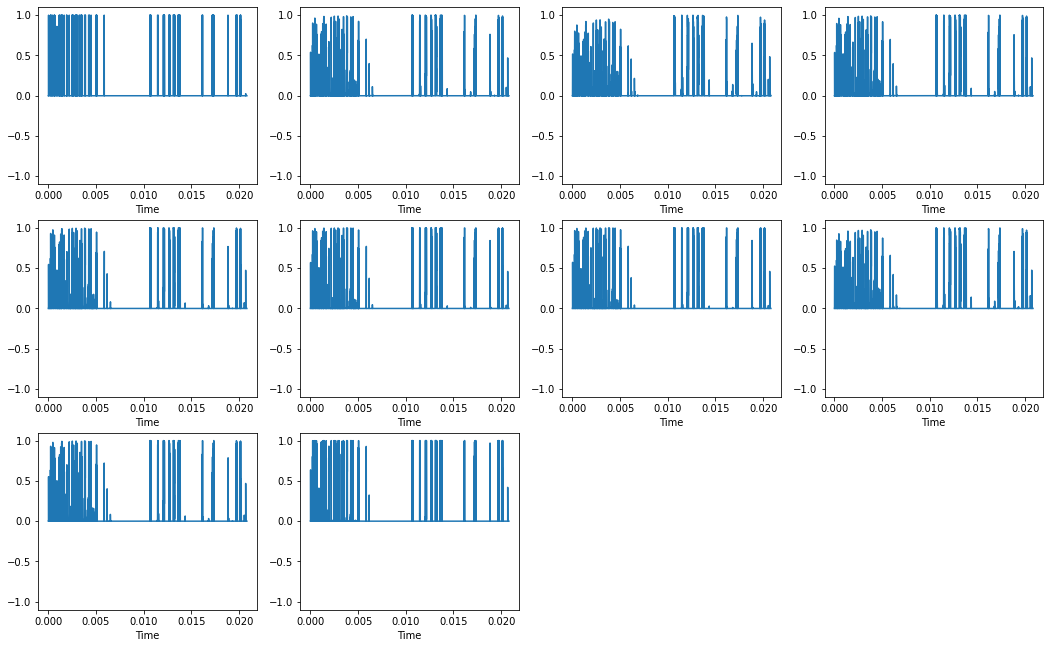

In [84]:
generate_and_save_images(model, 0, test_sample)


for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_x = np.asarray(train_x)[0]
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        test_x = np.asarray(test_x)[0]
        loss(compute_loss(model, test_x))
    display.clear_output(wait=False)
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

In [85]:
anim_file_2 = 'normal_cvae.gif'

with imageio.get_writer(anim_file_2, mode='I') as writer:
    filenames = glob.glob('normal*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if __name__ == "__main__":


In [86]:
#embed.embed_file(anim_file_2)

## Generated sounds - Classical

In [87]:
x2 = len(save_sound_U) 
print(x2)

50


In [88]:
n1=save_sound_U[0][0]
ipd.Audio(n1,rate=96000)
sf.write('gen1.wav', n1, 96000)  

In [89]:
n2=save_sound_U[1][0]
ipd.Audio(n2,rate=96000)
sf.write('gen2.wav', n2, 96000)  

In [90]:
n3=save_sound_U[2][0]
ipd.Audio(n3,rate=96000)
sf.write('gen3.wav', n3, 96000)  

In [91]:
n4=save_sound_U[3][0]
ipd.Audio(n4,rate=96000)
sf.write('gen4.wav', n4, 96000)  

In [92]:
n5=save_sound_U[4][0]
ipd.Audio(n5,rate=96000)
sf.write('gen5.wav', n5, 96000)  

In [93]:
n6=save_sound_U[5][0]
ipd.Audio(n6,rate=96000)
sf.write('gen6.wav', n6, 96000)  

In [94]:
n7=save_sound_U[6][0]
ipd.Audio(n7,rate=96000)
sf.write('gen7.wav', n7, 96000) 

In [95]:
n8=save_sound_U[7][0]
ipd.Audio(n8,rate=96000)
sf.write('gen8.wav', n8, 96000) 

In [96]:
n9=save_sound_U[8][0]
ipd.Audio(n9,rate=96000)
sf.write('gen9.wav', n9, 96000) 

In [97]:
n10=save_sound_U[9][0]
ipd.Audio(n10,rate=96000)
sf.write('gen10.wav', n10, 96000) 

In [98]:
n11=save_sound_U[10][0]
ipd.Audio(n11,rate=96000)
sf.write('gen11.wav', n11, 96000) 

In [99]:
n12=save_sound_U[11][0]
ipd.Audio(n12,rate=96000)
sf.write('gen12.wav', n12, 96000) 

In [100]:
n13=save_sound_U[12][0]
ipd.Audio(n13,rate=96000)
sf.write('gen13.wav', n13, 96000) 

In [101]:
n14=save_sound_U[13][0]
ipd.Audio(n14,rate=96000)
sf.write('gen14.wav', n14, 96000) 

In [102]:
n15=save_sound_U[14][0]
ipd.Audio(n15,rate=96000)
sf.write('gen15.wav', n15, 96000) 

In [103]:
n16=save_sound_U[15][0]
ipd.Audio(n16,rate=96000)
sf.write('gen16.wav', n16, 96000) 

In [104]:
n17=save_sound_U[16][0]
ipd.Audio(n17,rate=96000)
sf.write('gen17.wav', n17, 96000) 

In [105]:
n18=save_sound_U[17][0]
ipd.Audio(n18,rate=96000)
sf.write('gen18.wav', n18, 96000) 

In [106]:
n19=save_sound_U[18][0]
ipd.Audio(n19,rate=96000)
sf.write('gen19.wav', n19, 96000) 

In [107]:
n20=save_sound_U[19][0]
ipd.Audio(n20,rate=96000)
sf.write('gen20.wav', n20, 96000) 

In [108]:
n21=save_sound_U[20][0]
ipd.Audio(n21,rate=96000)
sf.write('gen21.wav', n21, 96000) 

In [109]:
n22=save_sound_U[21][0]
ipd.Audio(n22,rate=96000)
sf.write('gen22.wav', n22, 96000) 

In [110]:
n23=save_sound_U[22][0]
ipd.Audio(n23,rate=96000)
sf.write('gen23.wav', n23, 96000) 

In [111]:
n24=save_sound_U[23][0]
ipd.Audio(n24,rate=96000)
sf.write('gen24.wav', n24, 96000) 

In [112]:
n25=save_sound_U[24][0]
ipd.Audio(n25,rate=96000)
sf.write('gen25.wav', n25, 96000) 

In [113]:
n26=save_sound_U[25][0]
ipd.Audio(n26,rate=96000)
sf.write('gen26.wav', n26, 96000) 

In [114]:
n27=save_sound_U[26][0]
ipd.Audio(n27,rate=96000)
sf.write('gen27.wav', n27, 96000) 

In [115]:
n28=save_sound_U[27][0]
ipd.Audio(n28,rate=96000)
sf.write('gen28.wav', n28, 96000) 

In [116]:
n29=save_sound_U[28][0]
ipd.Audio(n29,rate=96000)
sf.write('gen29.wav', n29, 96000) 

In [117]:
n30=save_sound_U[29][0]
ipd.Audio(n30,rate=96000)
sf.write('gen30.wav', n30, 96000) 

In [118]:
n31=save_sound_U[30][0]
ipd.Audio(n31,rate=96000)
sf.write('gen31.wav', n31, 96000) 

In [119]:
n32=save_sound_U[31][0]
ipd.Audio(n32,rate=96000)
sf.write('gen32.wav', n32, 96000) 

In [120]:
n33=save_sound_U[32][0]
ipd.Audio(n33,rate=96000)
sf.write('gen33.wav', n33, 96000) 

In [121]:
n34=save_sound_U[33][0]
ipd.Audio(n34,rate=96000)
sf.write('gen34.wav', n34, 96000) 

In [122]:
n35=save_sound_U[34][0]
ipd.Audio(n35,rate=96000)
sf.write('gen35.wav', n35, 96000) 

In [123]:
n36=save_sound_U[35][0]
ipd.Audio(n36,rate=96000)
sf.write('gen36.wav', n36, 96000) 

In [124]:
n37=save_sound_U[36][0]
ipd.Audio(n37,rate=96000)
sf.write('gen37.wav', n37, 96000) 

In [125]:
n38=save_sound_U[37][0]
ipd.Audio(n38,rate=96000)
sf.write('gen38.wav', n38, 96000) 

In [126]:
n39=save_sound_U[38][0]
ipd.Audio(n39,rate=96000)
sf.write('gen39.wav', n39, 96000) 

In [127]:
n40=save_sound_U[39][0]
ipd.Audio(n40,rate=96000)
sf.write('gen40.wav', n40, 96000) 